### Imports

In [1]:
import json
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

### Analysis constants

In [2]:
data_path = "../main-analysis/data/main"    # folder structured as seed/data_set/target_model/attack
output_path = "output"

analysis_seed = 42
analysis_data_sets = ['ELD', 'EEG']
analysis_target_models = ['LSTM', 'NHiTS']
analysis_attack = 'rmia'            # Either lira or rmia
analysis_attack_version = 'online'  # Either online or offline
analysis_signals = ["MSELoss", "MAELoss", "SMAPELoss", "TrendLoss", "SeasonalityLoss", "TS2VecLoss"]    # Make sure ALL these are present in data for selected attack and version

## Signal Correlation

In [3]:
def plot_and_save_correlation(cmatrix, signal_names, data_set, target_model):

    # Plot the correlation matrix
    plt.figure(figsize=(8, 6))
    signal_names = [name.replace('Loss', '') for name in signal_names]
    sns.heatmap(
        cmatrix, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        xticklabels=signal_names, 
        yticklabels=signal_names
    )
    attack_name = 'LiRA' if analysis_attack == 'lira' else 'RMIA'
    plt.title(f"Correlation Matrix of {attack_name} signals - {data_set} {target_model.replace('NH', 'N-H')}")

    # Save and show figure
    plt.savefig(f"output/figures/{data_set}-{target_model}-{attack_name}")
    plt.show()

Processing attack run 1/4: ELD LSTM:   0%|          | 0/44 [00:00<?, ?it/s]

Processing attack run 1/4: ELD LSTM: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]


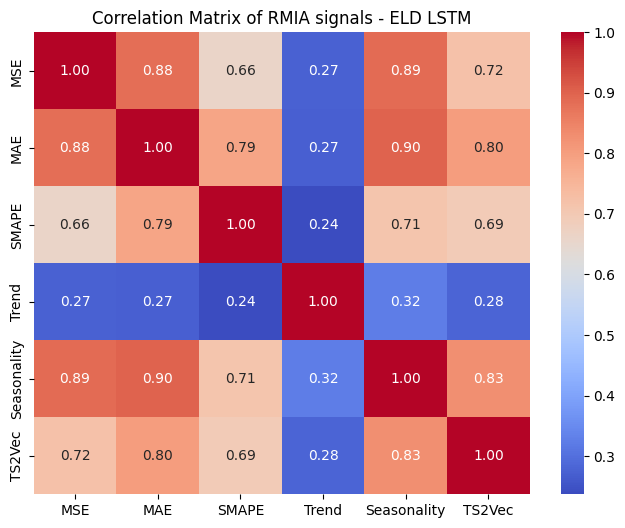

Processing attack run 2/4: ELD NHiTS: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


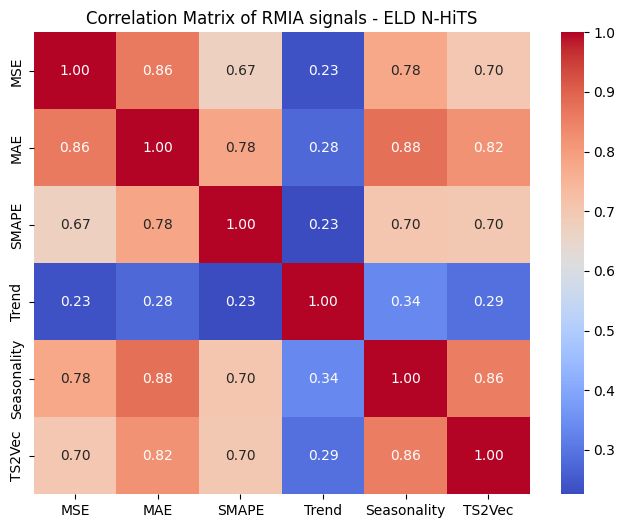

Loaded saved cmatrix for 42-EEG-LSTM-rmia-online


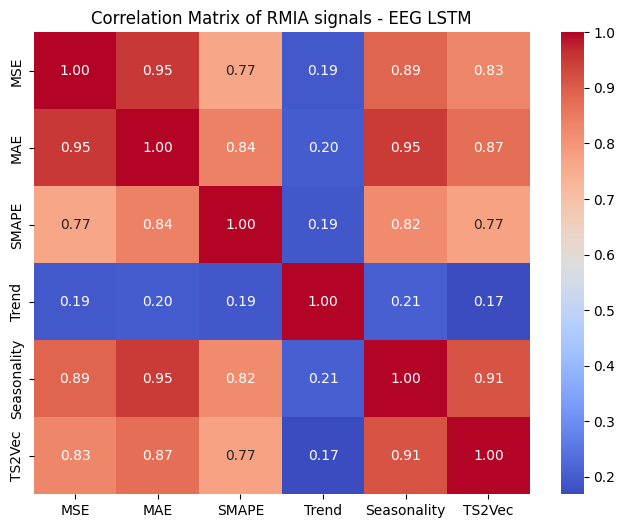

Loaded saved cmatrix for 42-EEG-NHiTS-rmia-online


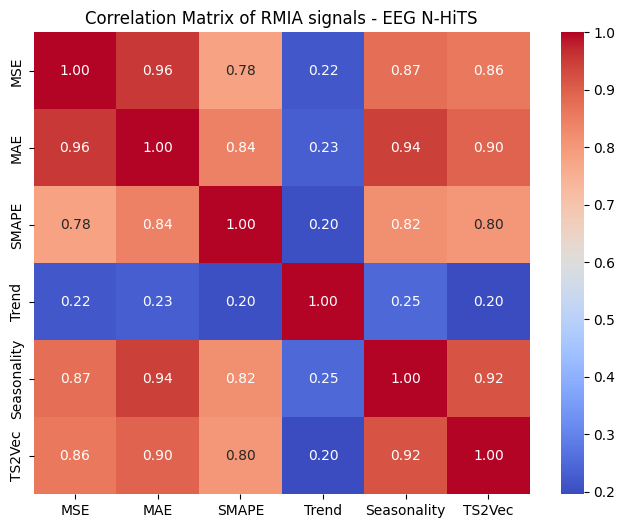

In [4]:
# Create output dirs if not present
output_paths = [output_path, f"{output_path}/cmatrices", f"{output_path}/figures"]
for path in output_paths:
    if not os.path.exists(path):
        os.mkdir(path)

# Get stored correlation matrices
stored_cmatrices = os.listdir(f"{output_path}/cmatrices")

# Compute and save all cmatrices
i = 0
tot_cmatrices = len(analysis_data_sets) * len(analysis_target_models)
for data_set in analysis_data_sets:
    for model in analysis_target_models:

        cmatrix_id = f"{analysis_seed}-{data_set}-{model}-{analysis_attack}-{analysis_attack_version}"

        # Load cmatrix if already exists
        if cmatrix_id in stored_cmatrices:
            with open(f"{output_path}/cmatrices/{cmatrix_id}", 'rb') as file:
                print(f"Loaded saved cmatrix for {cmatrix_id}")
                cmatrix = pickle.load(file)

        # Else compute it and save
        else:
            signal_scores = {}
            analysis_is_online = True if analysis_attack_version == 'online' else False
            for attack in tqdm(os.listdir(f"{data_path}/{analysis_seed}/{data_set}/{model}"), desc=f"Processing attack run {i+1}/{tot_cmatrices}: {data_set} {model}"):
                with open(f"{data_path}/{analysis_seed}/{data_set}/{model}/{attack}/result.json", 'r') as file:
                    result = json.load(file)

                if result['result_name'].lower() == analysis_attack and result['config']['online'] == analysis_is_online:
                    signal_name = result['config']['signal_name']
                    mia_scores = result['signal_values']
                    signal_scores[signal_name] = mia_scores

            # Compute and save correlation coefficient matrix
            likelihood_matrix = np.array([signal_scores[name] for name in analysis_signals]) 
            correlation_matrix = np.corrcoef(likelihood_matrix)     
            with open(f"{output_path}/cmatrices/{cmatrix_id}", 'wb') as file:
                pickle.dump(correlation_matrix, file)
            cmatrix = correlation_matrix

        # Plot it
        plot_and_save_correlation(cmatrix, analysis_signals, data_set, model)
        i += 1